# Decision Trees Exercises


# Learning Objectives

- Recognize Decision trees and how to use them for classification problems
- Recognize how to identify the best split and the factors for splitting
- Explain strengths and weaknesses of decision trees
- Explain how regression trees help with classifying continuous values
- Apply Intel® Extension for Scikit-learn* to leverage underlying compute capabilities of hardware

# scikit-learn*

Frameworks provide structure that Data Scientists use to build code. Frameworks are more than just libraries, because in addition to callable code, frameworks influence how code is written.

A main virtue of using an optimized framework is that code runs faster. Code that runs faster is just generally more convenient but when we begin looking at applied data science and AI models, we can see more material benefits. Here you will see how optimization, particularly hyperparameter optimization can benefit more than just speed.

These exercises will demonstrate how to apply **the Intel® Extension for Scikit-learn*,** a seamless way to speed up your Scikit-learn application. The acceleration is achieved through the use of the Intel® oneAPI Data Analytics Library (oneDAL). Patching is the term used to extend scikit-learn with Intel optimizations and makes it a well-suited machine learning framework for dealing with real-life problems.

To get optimized versions of many Scikit-learn algorithms using a patch() approach consisting of adding these lines of code after importing sklearn:

- **from sklearnex import patch_sklearn**
- **patch_sklearn()**

## This exercise relies on installation of  Intel® Extension for Scikit-learn*

If you have not already done so, follow the instructions from Week 1 for instructions

## Introduction

We will be using the wine quality data set for these exercises. This data set contains various chemical properties of wine, such as acidity, sugar, pH, and alcohol. It also contains a quality metric (3-9, with highest being better) and a color (red or white). The name of the file is `Wine_Quality_Data.csv`.

In [ ]:
# Install scikit-learn-intelex for accelerated scikit-learn operations (optional, mainly for Colab environments)
!pip install scikit-learn-intelex

from __future__ import print_function # Ensure compatibility with Python 2 and 3 print function
import os
data_path = ['data'] # Define the path where the data is stored

from io import StringIO
from IPython.display import Image, display # For displaying images and other content in IPython

from sklearn.tree import export_graphviz # For exporting the decision tree in DOT format
from sklearn.model_selection import StratifiedShuffleSplit # For creating stratified splits of the dataset
from sklearn.metrics import mean_squared_error # For computing the mean squared error metric
from sklearn.tree import DecisionTreeRegressor # For creating a decision tree regressor model
from sklearn.model_selection import GridSearchCV # For performing grid search with cross-validation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # For computing classification metrics
from sklearn.tree import DecisionTreeClassifier # For creating a decision tree classifier model

from sklearnex import patch_sklearn # Patch scikit-learn with Intel(R) Extension for Scikit-learn for improved performance
patch_sklearn() # Apply the patch

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Part 1: Setup and Data Preparation
* Installation and Imports: Initially, the tutorial starts with setting up the environment, which includes installing necessary libraries and importing them. scikit-learn-intelex is used to patch scikit-learn to accelerate machine learning algorithms on Intel hardware.

* Data Loading: The wine quality dataset is loaded into a pandas DataFrame. This dataset includes various features like acidity, sugar, pH, etc., and aims to classify wine into red or white.

* Data Examination: Basic commands like data.head() and data.dtypes are used to inspect the first few rows of the dataset and the data types of each column, respectively. This helps in understanding the structure of the data and planning preprocessing steps.
Preprocessing: The 'color' feature, which is categorical, is converted into an integer format. This is a common practice in machine learning to convert categorical variables into numerical ones to facilitate computation.

In [ ]:
import pandas as pd
import numpy as np

# Create the full file path by joining directory and file name
filepath = os.sep.join(data_path + ['Wine_Quality_Data.csv'])
# Load the dataset from the specified file
data = pd.read_csv(filepath, sep=',')

In [ ]:
# Display the first few rows of the dataset
data.head()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality color  
0      9.4        5   red  
1      9.8        5   red  
2      9.8        5   red  
3      9.8        6   red  
4      9.4        5   red

In [ ]:
# Display the data types of each column in the DataFrame
data.dtypes

fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
color                    object
dtype: object

Convert the color feature to an integer. This is a quick way to do it using Pandas.

In [ ]:
# Convert the 'color' column to numeric values: white to 0 and red to 1
data['color'] = data.color.replace('white', 0).replace('red', 1).astype(int)

In [ ]:
data.dtypes

fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
color                     int64
dtype: object

In [ ]:
data.head()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  color  
0      9.4        5      1  
1      9.8        5      1  
2      9.8        5      1  
3      9.8        6      1  
4      9.4        5      1

## Part 2: Data Splitting
* Feature Selection: All columns except 'color' are selected as features for the model.

* Data Splitting: StratifiedShuffleSplit is used to create a stratified split of the dataset into training and test sets. Stratification ensures that both sets have a similar distribution of the target variable, which is crucial for maintaining consistency and avoiding bias in model training and evaluation.
Composition Check: The distribution of the target variable ('color' in this case) is checked in both training and test sets to confirm the stratification.

In [ ]:
# Define the feature columns (all columns except 'color')
feature_cols = [x for x in data.columns if x not in 'color']


In [ ]:
# Initialize StratifiedShuffleSplit object with 1 split, 1000 test size, and a random seed for reproducibility
strat_shuff_split = StratifiedShuffleSplit(n_splits=1, test_size=1000, random_state=42)

# Generate train and test indices using the stratified shuffle split object
train_idx, test_idx = next(strat_shuff_split.split(data[feature_cols], data['color']))

# Slice the data into training and test sets using the generated indices
x_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'color']
x_test = data.loc[test_idx, feature_cols]
y_test = data.loc[test_idx, 'color']

Now check the percent composition of each quality level in the train and test data sets. The data set is mostly white wine, as can be seen below.

In [ ]:
# Display the distribution of 'color' in the training set
y_train.value_counts().sort_index()

0    4144
1    1353
Name: color, dtype: int64

In [ ]:
# Display the normalized distribution of 'color' in the test set
y_train.value_counts(normalize=True).sort_index()

0    0.753866
1    0.246134
Name: color, dtype: float64

## Part 3: Decision Tree Classifier
* Model Training: A Decision Tree Classifier is trained on the dataset without any constraints on its depth or the number of leaves. This often leads to a very complex model that can overfit the training data.

* Model Complexity Analysis: The depth and number of nodes of the trained tree are examined. A large number of nodes and depth usually indicate a complex model, which might not generalize well to unseen data.

* Evaluation: The model's performance is evaluated using metrics such as accuracy, precision, recall, and F1 score. Overfitting is discussed in the context of differences in prediction errors between the training and test datasets.

In [ ]:
# Initialize and train a DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt = dt.fit(x_train, y_train)

The number of nodes and the maximum actual depth.

In [ ]:
# Display the number of nodes and the maximum depth of the trained tree
dt.tree_.node_count, dt.tree_.max_depth

(171, 22)

A function to return error metrics.

In [ ]:
# Define a function to calculate and return error metrics
def measure_error(y_true, y_pred, label):
    return pd.Series({'accuracy':accuracy_score(y_true, y_pred),
                      'precision': precision_score(y_true, y_pred),
                      'recall': recall_score(y_true, y_pred),
                      'f1': f1_score(y_true, y_pred)},
                      name=label)

The decision tree predicts a little better on the training data than the test data, which is consistent with (mild)  overfitting. Also notice the perfect recall score for the training data. In many instances, this prediction difference is even greater than that seen here.

In [ ]:
# Predict on training and test sets
y_train_pred = dt.predict(x_train)
y_test_pred = dt.predict(x_test)

# Calculate error metrics for both sets and concatenate the results
train_test_full_error = pd.concat([measure_error(y_train, y_train_pred, 'train'),
                                   measure_error(y_test, y_test_pred, 'test')],
                                   axis=1)

# Display the error metrics
train_test_full_error

train      test
accuracy   0.999818  0.984000
precision  0.999261  0.963710
recall     1.000000  0.971545
f1         0.999631  0.967611

## Part 4: Model Optimization
* Hyperparameter Tuning: GridSearchCV is used to perform a grid search with cross-validation to find optimal hyperparameters for the decision tree, aiming to balance model complexity and performance. This process seeks to improve the model's generalization to unseen data.

* Evaluation and Comparison: The optimized model is evaluated using the same metrics, and its performance is compared to the initial, unconstrained model. The optimized model should ideally perform better on the test set due to reduced overfitting.

In [ ]:
# Define a parameter grid for GridSearchCV
param_grid = { 'max_depth' : range(1, dt.tree_.max_depth+1, 2),
              'max_features': range(1, len(dt.feature_importances_)+1)}

# Initialize and fit a GridSearchCV with a DecisionTreeClassifier
GR = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid = param_grid,
                  scoring= 'accuracy',
                  n_jobs= -1)
GR = GR.fit(x_train, y_train)

The number of nodes and the maximum depth of the tree.

In [ ]:
# Display node count and max depth of best estimator
GR.best_estimator_.tree_.node_count, GR.best_estimator_.tree_.max_depth

(99, 7)

These test errors are a little better than the previous ones. So it would seem the previous example overfit the data, but only slightly so.

In [ ]:
# Predict on training and test sets using the best estimator from GridSearchCV
y_train_pred_gr = GR.predict(x_train)
y_test_pred_gr = GR.predict(x_test)

# Calculate and display error metrics for both sets using the best estimator
train_test_gr_error = pd.concat([measure_error(y_train, y_train_pred_gr, 'train'),
                                 measure_error(y_test, y_test_pred_gr, 'test')],
                                axis= 1)

# Display error metrics
train_test_gr_error

train      test
accuracy   0.995816  0.989000
precision  0.998501  0.983539
recall     0.984479  0.971545
f1         0.991440  0.977505

## Part 5: Decision Tree Regressor
* Problem Re-definition: The problem is shifted from classification to regression, with 'residual_sugar' as the target variable. This demonstrates the versatility of decision trees in handling both classification and regression tasks. Re-split the data into `X` and `y` parts, this time with `residual_sugar` being the predicted (`y`) data. *Note:* if the indices were preserved from the `StratifiedShuffleSplit` output in question 2, they can be used again to split the data.

* Model Training and Tuning: A Decision Tree Regressor is trained and optimized using a similar approach to Part 4, adjusted for regression (e.g., using mean squared error as the performance metric).

* Evaluation: The regression model's performance is evaluated on the training and test sets, and a plot of actual vs. predicted 'residual_sugar' values is created to visualize the model's predictions.

In [ ]:
# Exclude 'residual_sugar' from feature columns for regression task
feature_cols = [x for x in data.columns if x != 'residual_sugar']

# Slice the data into new training and test sets for regression task
x_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'residual_sugar']
x_test = data.loc[test_idx, feature_cols]
y_test = data.loc[test_idx, 'residual_sugar']

In [ ]:
# Initialize and fit a DecisionTreeRegressor
dr = DecisionTreeRegressor().fit(x_train, y_train)

# Define a parameter grid for GridSearchCV for regression task
param_grid = { 'max_depth' : range(1, dr.tree_.max_depth+1, 2),
              'max_features': range(1, len(dr.feature_importances_)+1)}

# Initialize and fit a GridSearchCV with a DecisionTreeRegressor
GR_sugar = GridSearchCV(DecisionTreeRegressor(random_state=42),
                  param_grid = param_grid,
                  scoring= 'neg_mean_squared_error',
                  n_jobs= -1)
GR_sugar = GR.fit(x_train, y_train)

The number of nodes and the maximum depth of the tree. This tree has lots of nodes, which is not so surprising given the continuous data.

In [ ]:
# Display the total number of nodes and the maximum depth of the decision tree for the best 'residual_sugar'
# regression model found by GridSearchCV, indicating the complexity and potential overfitting risk of the model.

GR_sugar.best_estimator_.tree_.node_count, GR_sugar.best_estimator_.tree_.max_depth

(7953, 25)

The error on train and test data sets. Since this is continuous, we will use mean squared error.

In [ ]:
# Predict on training and test sets using the best estimator for regression task
y_train_pred_gr_sugar = GR_sugar.predict(x_train)
y_test_pred_gr_sugar = GR_sugar.predict(x_test)

# Calculate and display mean squared error for both sets using the best estimator for regression task
train_test_gr_sugar_error = pd.Series({'train':mean_squared_error(y_train, y_train_pred_gr_sugar),
                                       'test': mean_squared_error(y_test, y_test_pred_gr_sugar)},
                                      name= 'MSE').to_frame().T

A plot of actual vs predicted residual sugar.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the visual context, style, and color palette for seaborn plots
sns.set_context('notebook')
sns.set_style('white')
sns.set_palette('dark')

%matplotlib inline

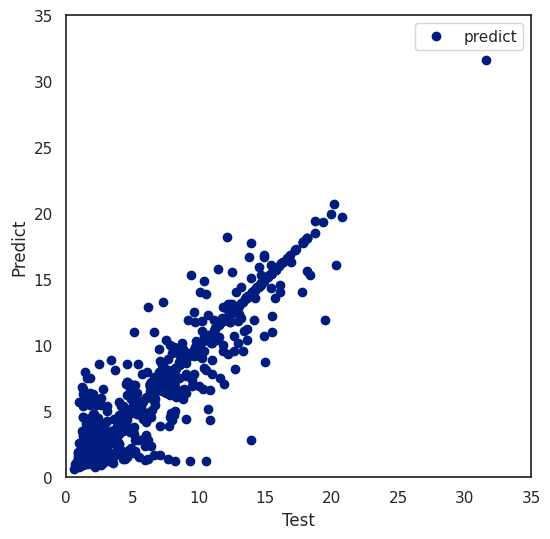

In [ ]:
# Plot the relationship between actual and predicted values for the regression task
fig = plt.figure(figsize=(6,6))
ax = plt.axes()

ph_test_predict = pd.DataFrame({'test':y_test.values,
                                'predict': y_test_pred_gr_sugar}).set_index('test').sort_index()

ph_test_predict.plot(marker='o', ls='', ax=ax)
ax.set(xlabel='Test', ylabel='Predict', xlim=(0,35), ylim=(0,35));

## Part 6: Visualization *(Optional)*

Visualizing decision trees can help in interpreting the model's decision-making process and identifying how different features contribute to predictions.

This question is optional as it requires an additional command line program (GraphViz) and Python library (PyDotPlus). GraphViz can be installed with a package manager on Linux and Mac. For PyDotPlus, either `pip` or `conda` (`conda install -c conda-forge pydotplus`) can be used to install the library.

Once these programs are installed:

* Create a visualization of the decision tree from question 3, where wine color was predicted and the number of features and/or splits are not limited.
* Create a visualization of the decision tree from question 4, where wine color was predicted but a grid search was used to find the optimal depth and number of features.

The decision tree from question 5 will likely have too many nodes to visualize.

In [ ]:
# Attempt to import pydotplus for visualizing decision trees
try:
    import pydotplus
    pydotplus_installed = True

except:
    print('PyDotPlus must be installed to execute the remainder of the cells associated with this question.')
    print('Please see the instructions for this part for details.')
    pydotplus_installed = False

The tree from question 3.

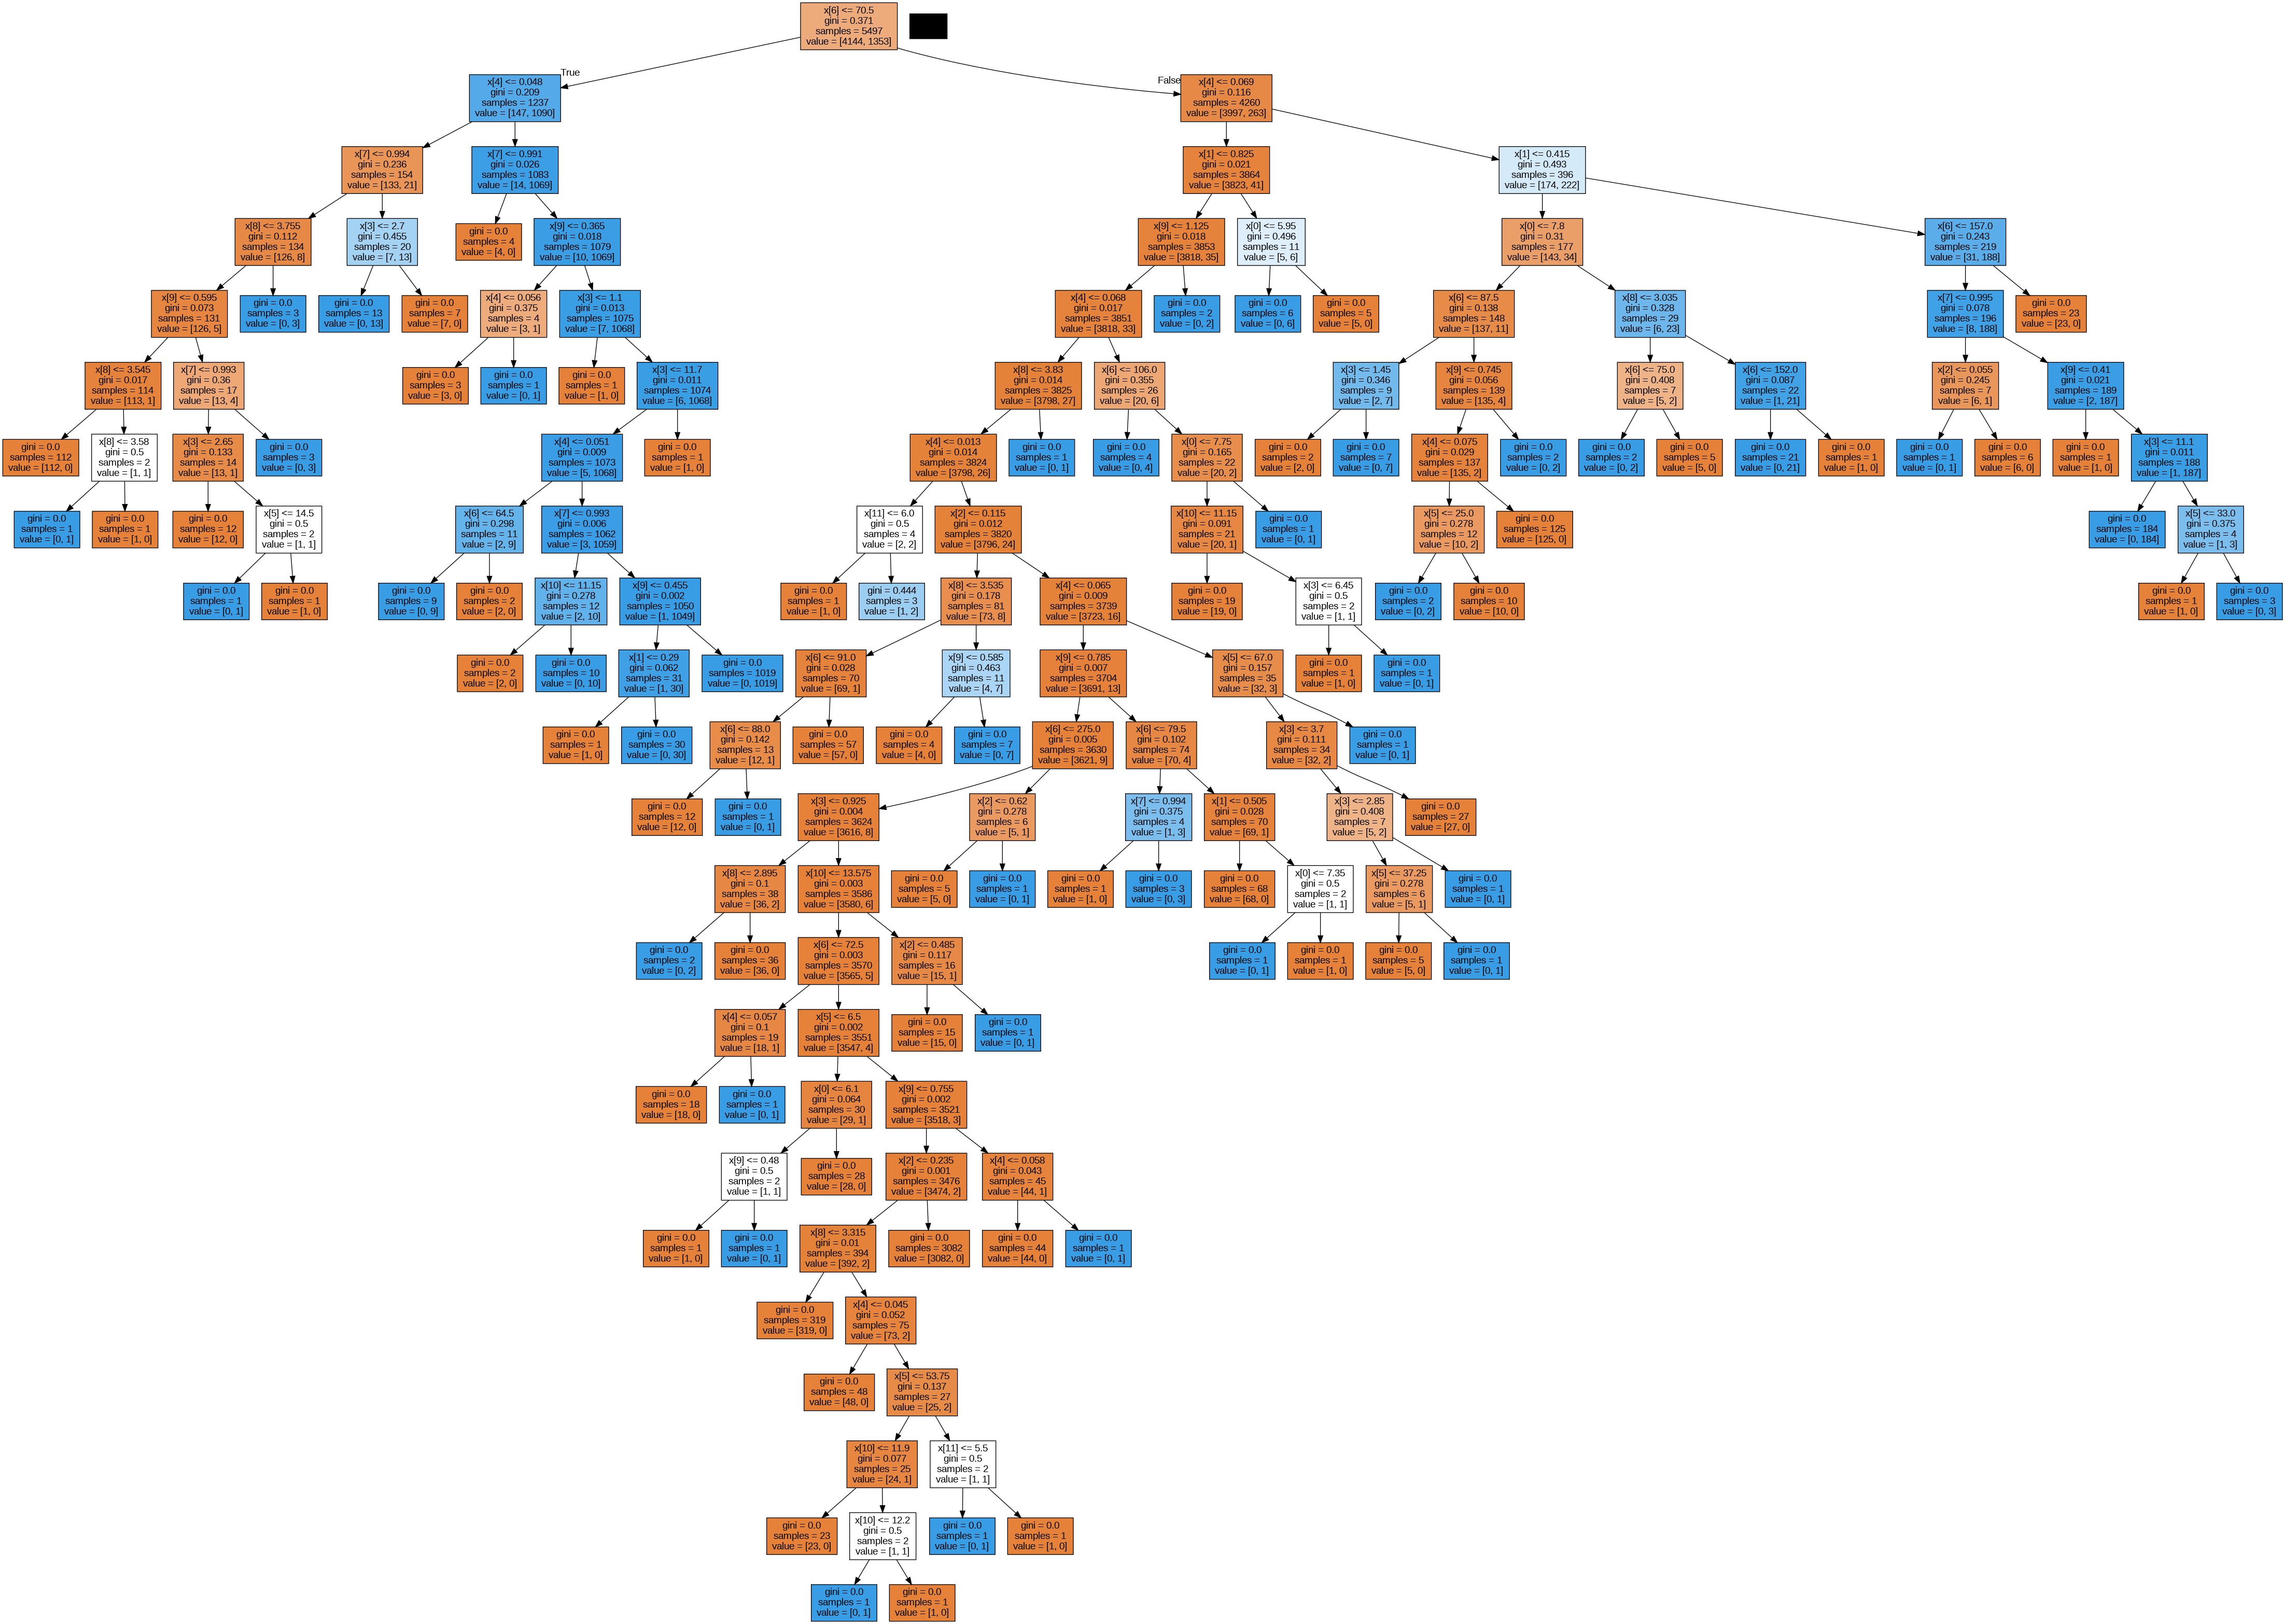

In [ ]:
# If pydotplus is installed, export and display the decision tree
if pydotplus_installed:

    # Create an output destination for the file
    dot_data = StringIO()

    # Export the decision tree to DOT format
    export_graphviz(dt, out_file=dot_data, filled=True)
    # Generate the graph from DOT data
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

    # Save and display the tree image
    filename = 'wine_tree.png'
    graph.write_png(filename)
    img = Image(filename=filename)
    display(img)

else:
    print('This cell not executed because PyDotPlus could not be loaded.')


The tree fit with cross validation from question 4. This tree is much shallower than the previous one.

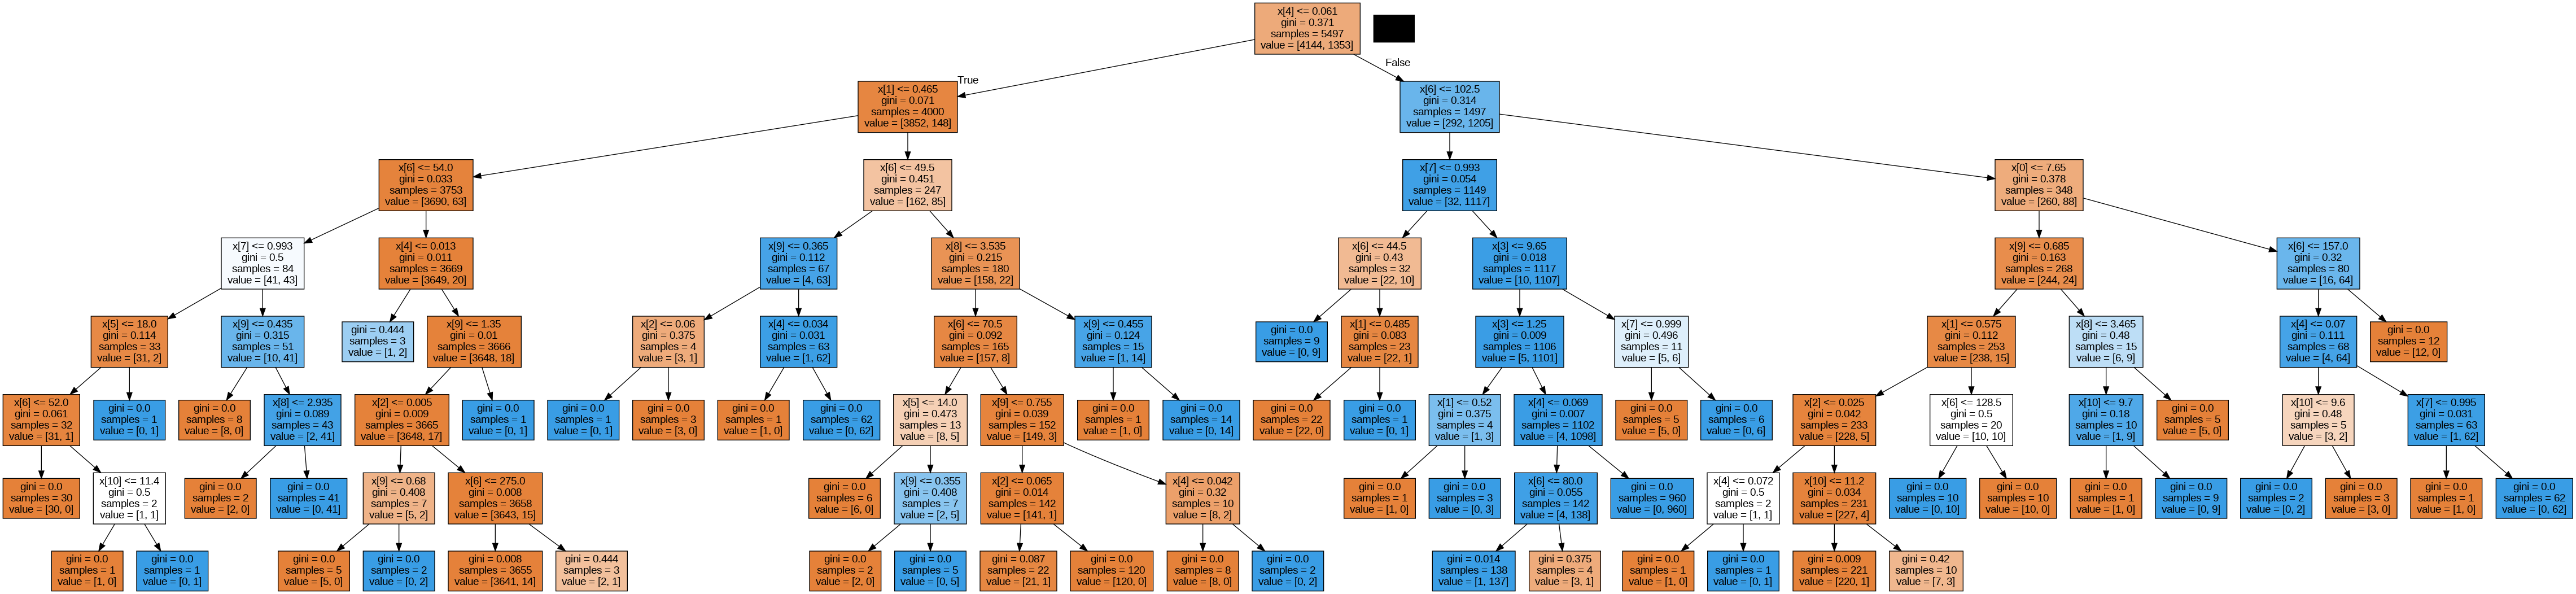

In [ ]:
# Repeat the process for the pruned tree from GridSearchCV
if pydotplus_installed:

    dot_data = StringIO()

    export_graphviz(GR.best_estimator_, out_file=dot_data, filled=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

    filename = 'wine_tree_prune.png'
    graph.write_png(filename)
    img = Image(filename=filename)
    display(img)

else:
    print('This cell not executed because PyDotPlus could not be loaded.')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.111091 to fit



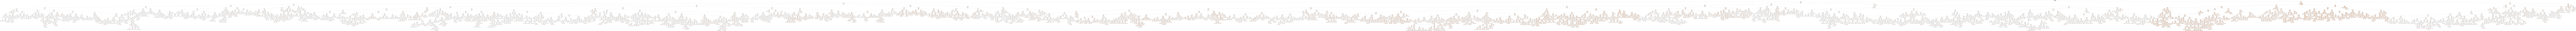

In [ ]:
# Repeat the process for the pruned tree from GridSearchCV
if pydotplus_installed:

    dot_data = StringIO()

    export_graphviz(GR_sugar.best_estimator_, out_file=dot_data, filled=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

    filename = 'wine_tree_sugars.png'
    graph.write_png(filename)
    img = Image(filename=filename)
    display(img)

else:
    print('This cell not executed because PyDotPlus could not be loaded.')